# Cluster participants
This notebook contains scripts to cluster participants based on their behavioral performance using k-means. The cluster assignment information is then saved into the data file, so this notebook does not need to be run again. 

## Imports

In [5]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy import stats
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

import pickle

import helpers
import scienceplots
plt.style.use(['science','no-latex'])
# plt.style.use(['science','ieee','no-latex'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data

In [2]:
with open('data.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    all_data = data_dict['data']
    meta_data = data_dict['meta_data']

## Cluster data

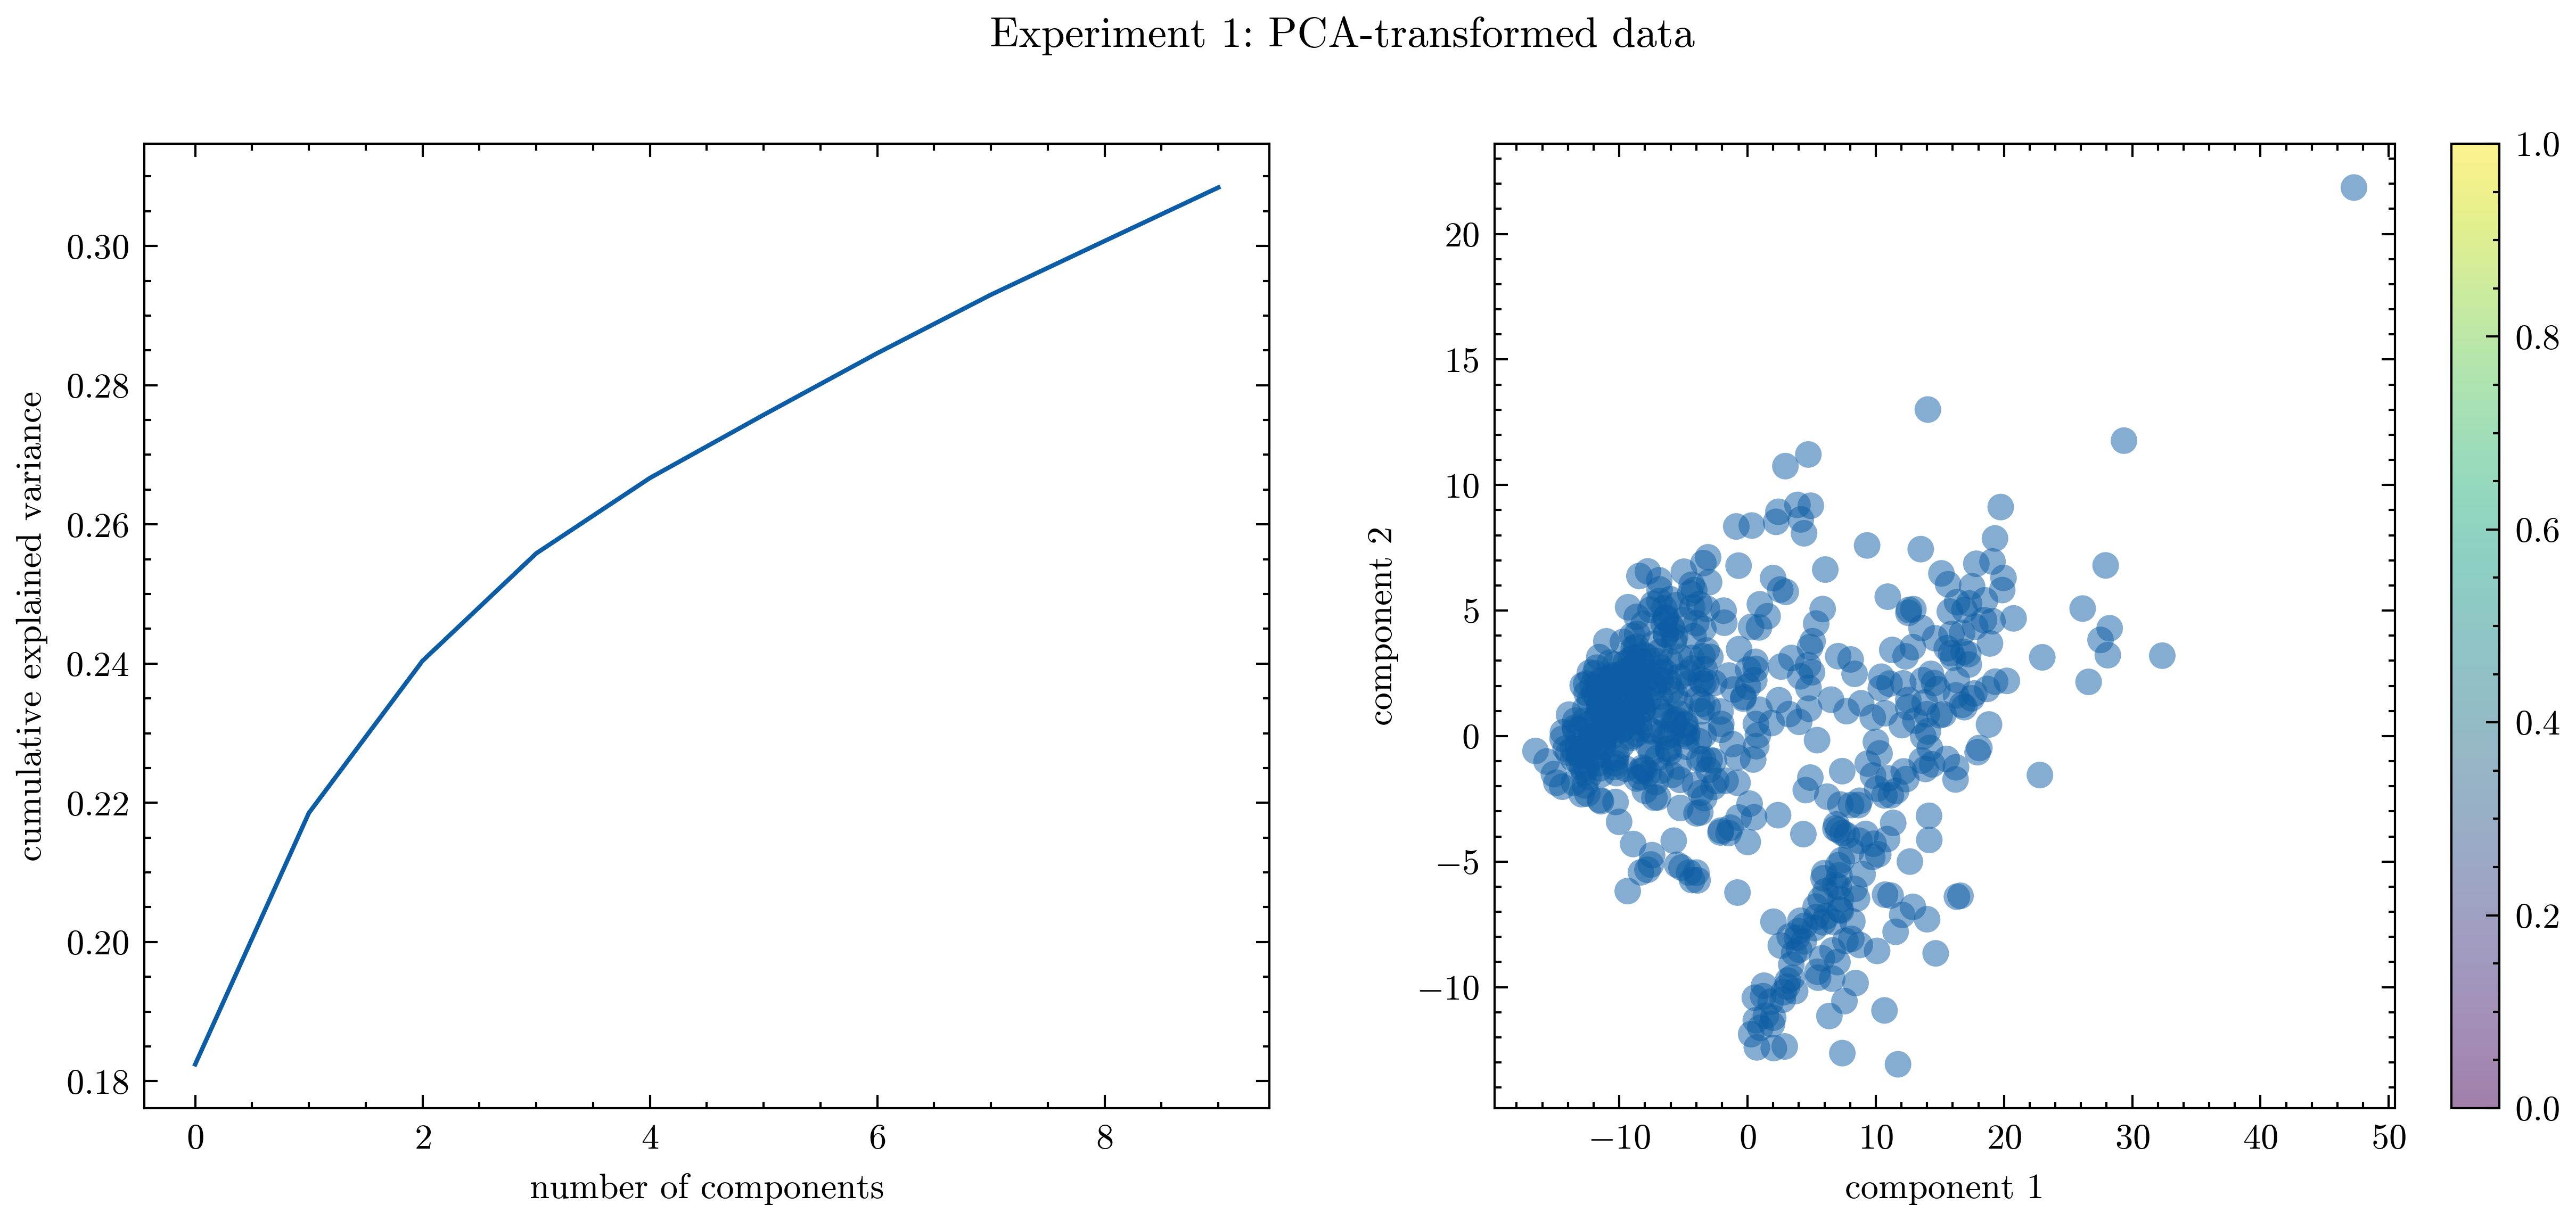

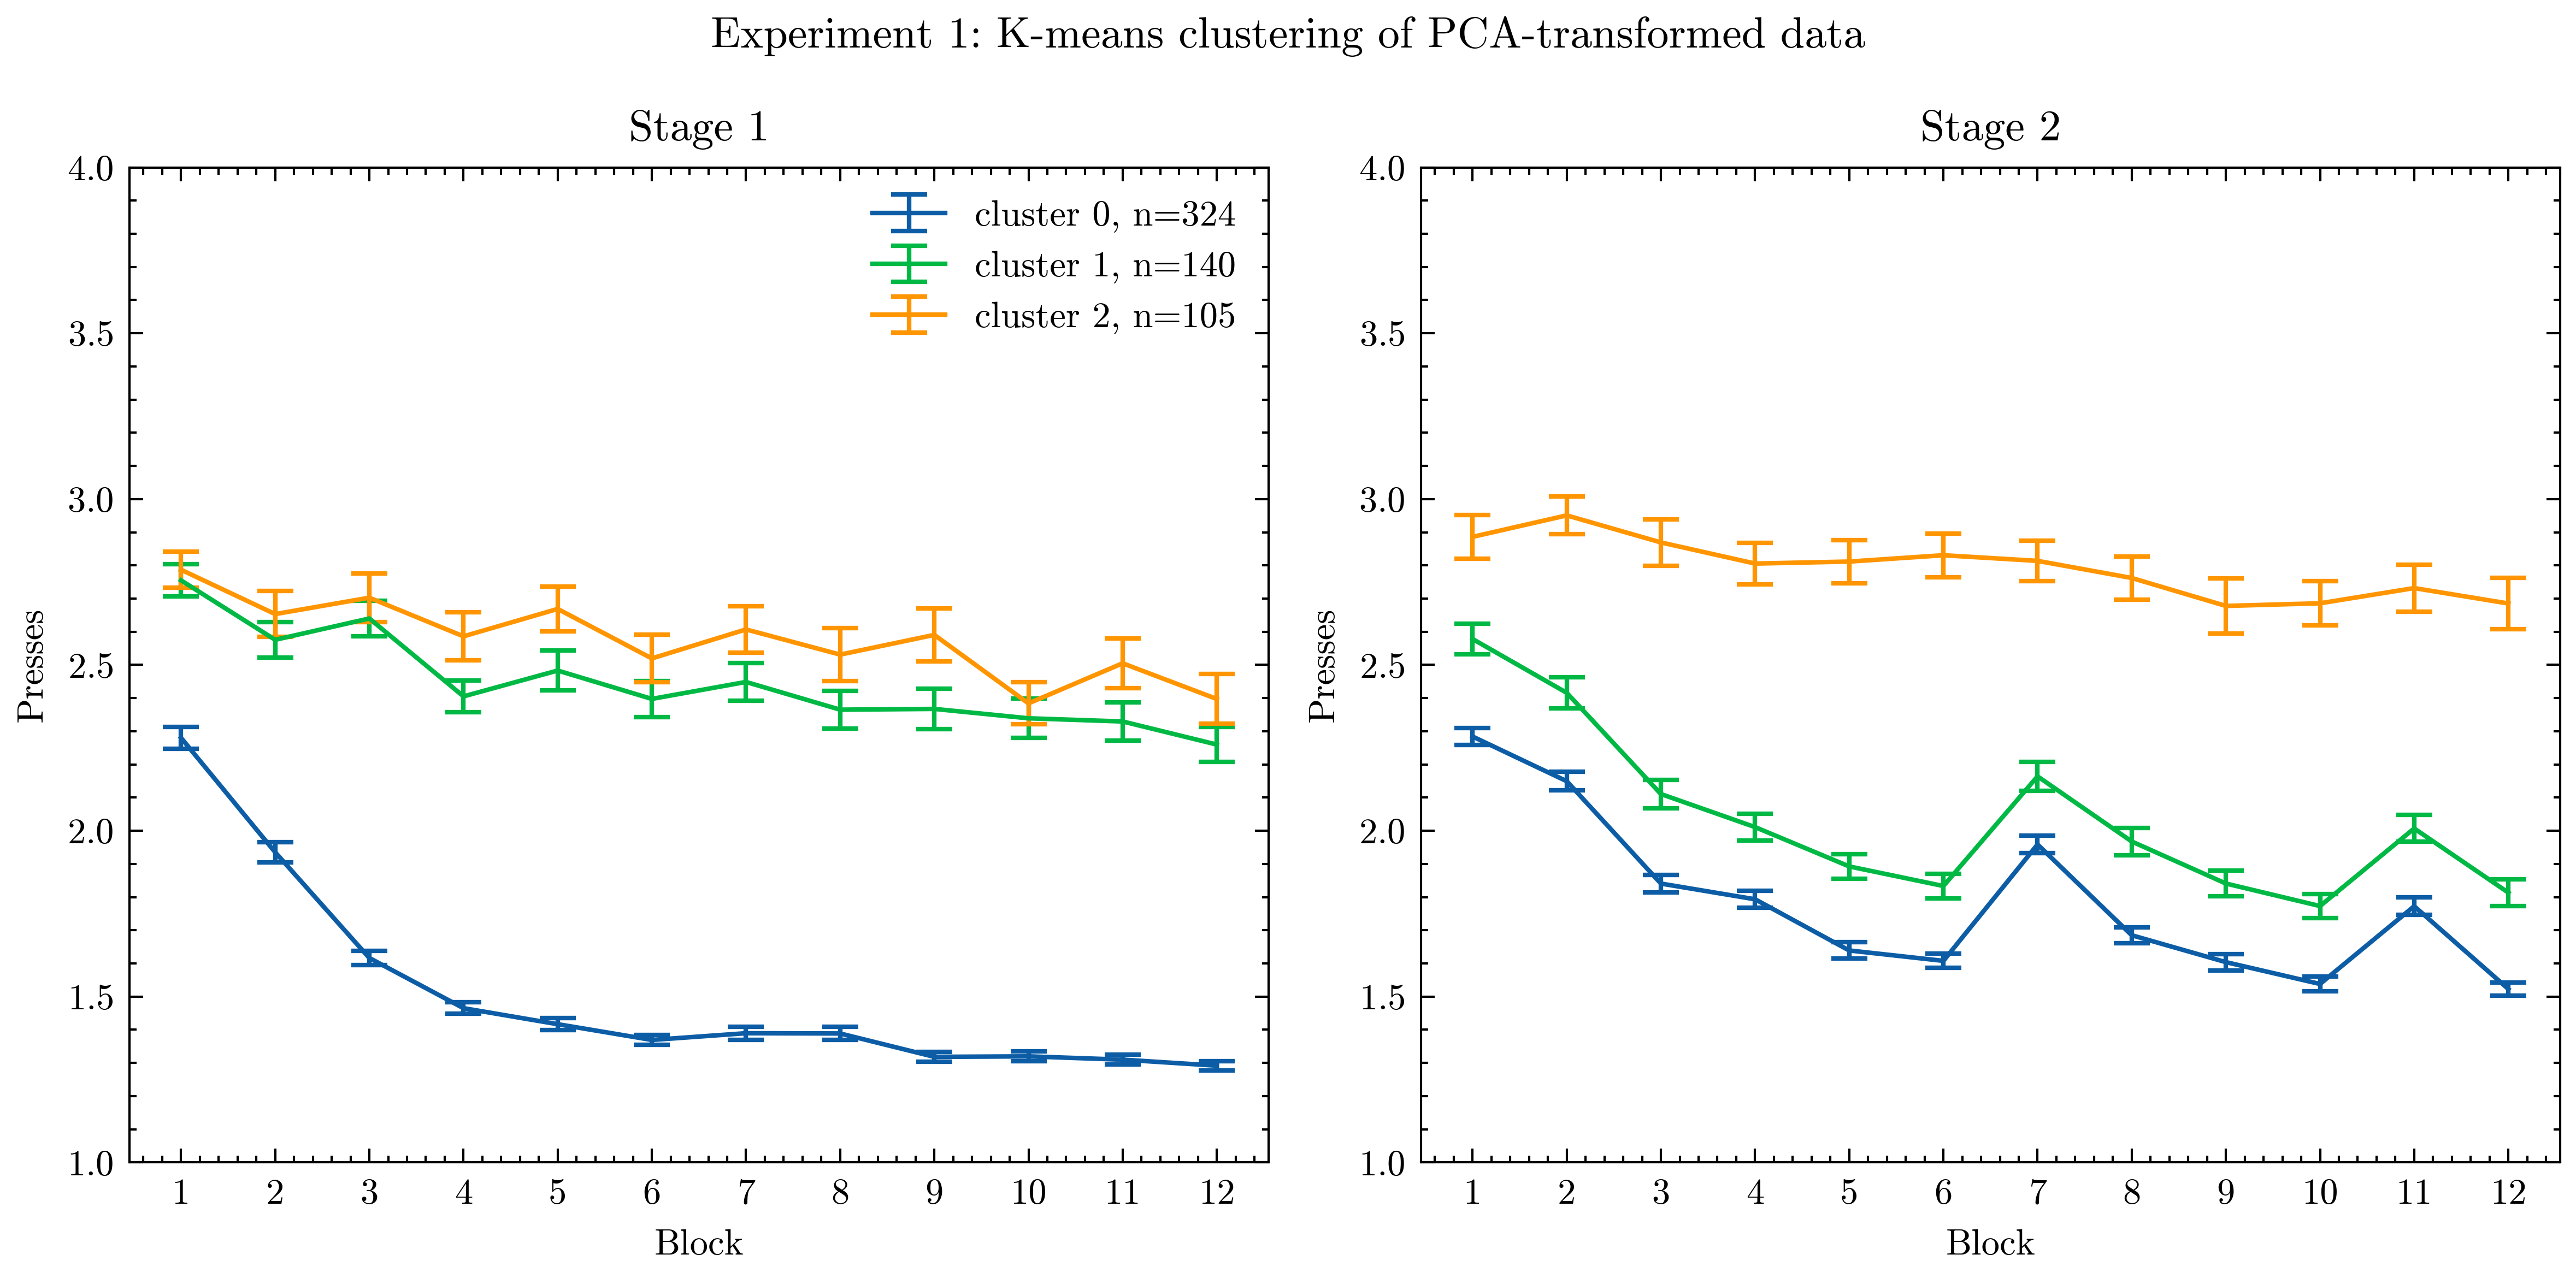

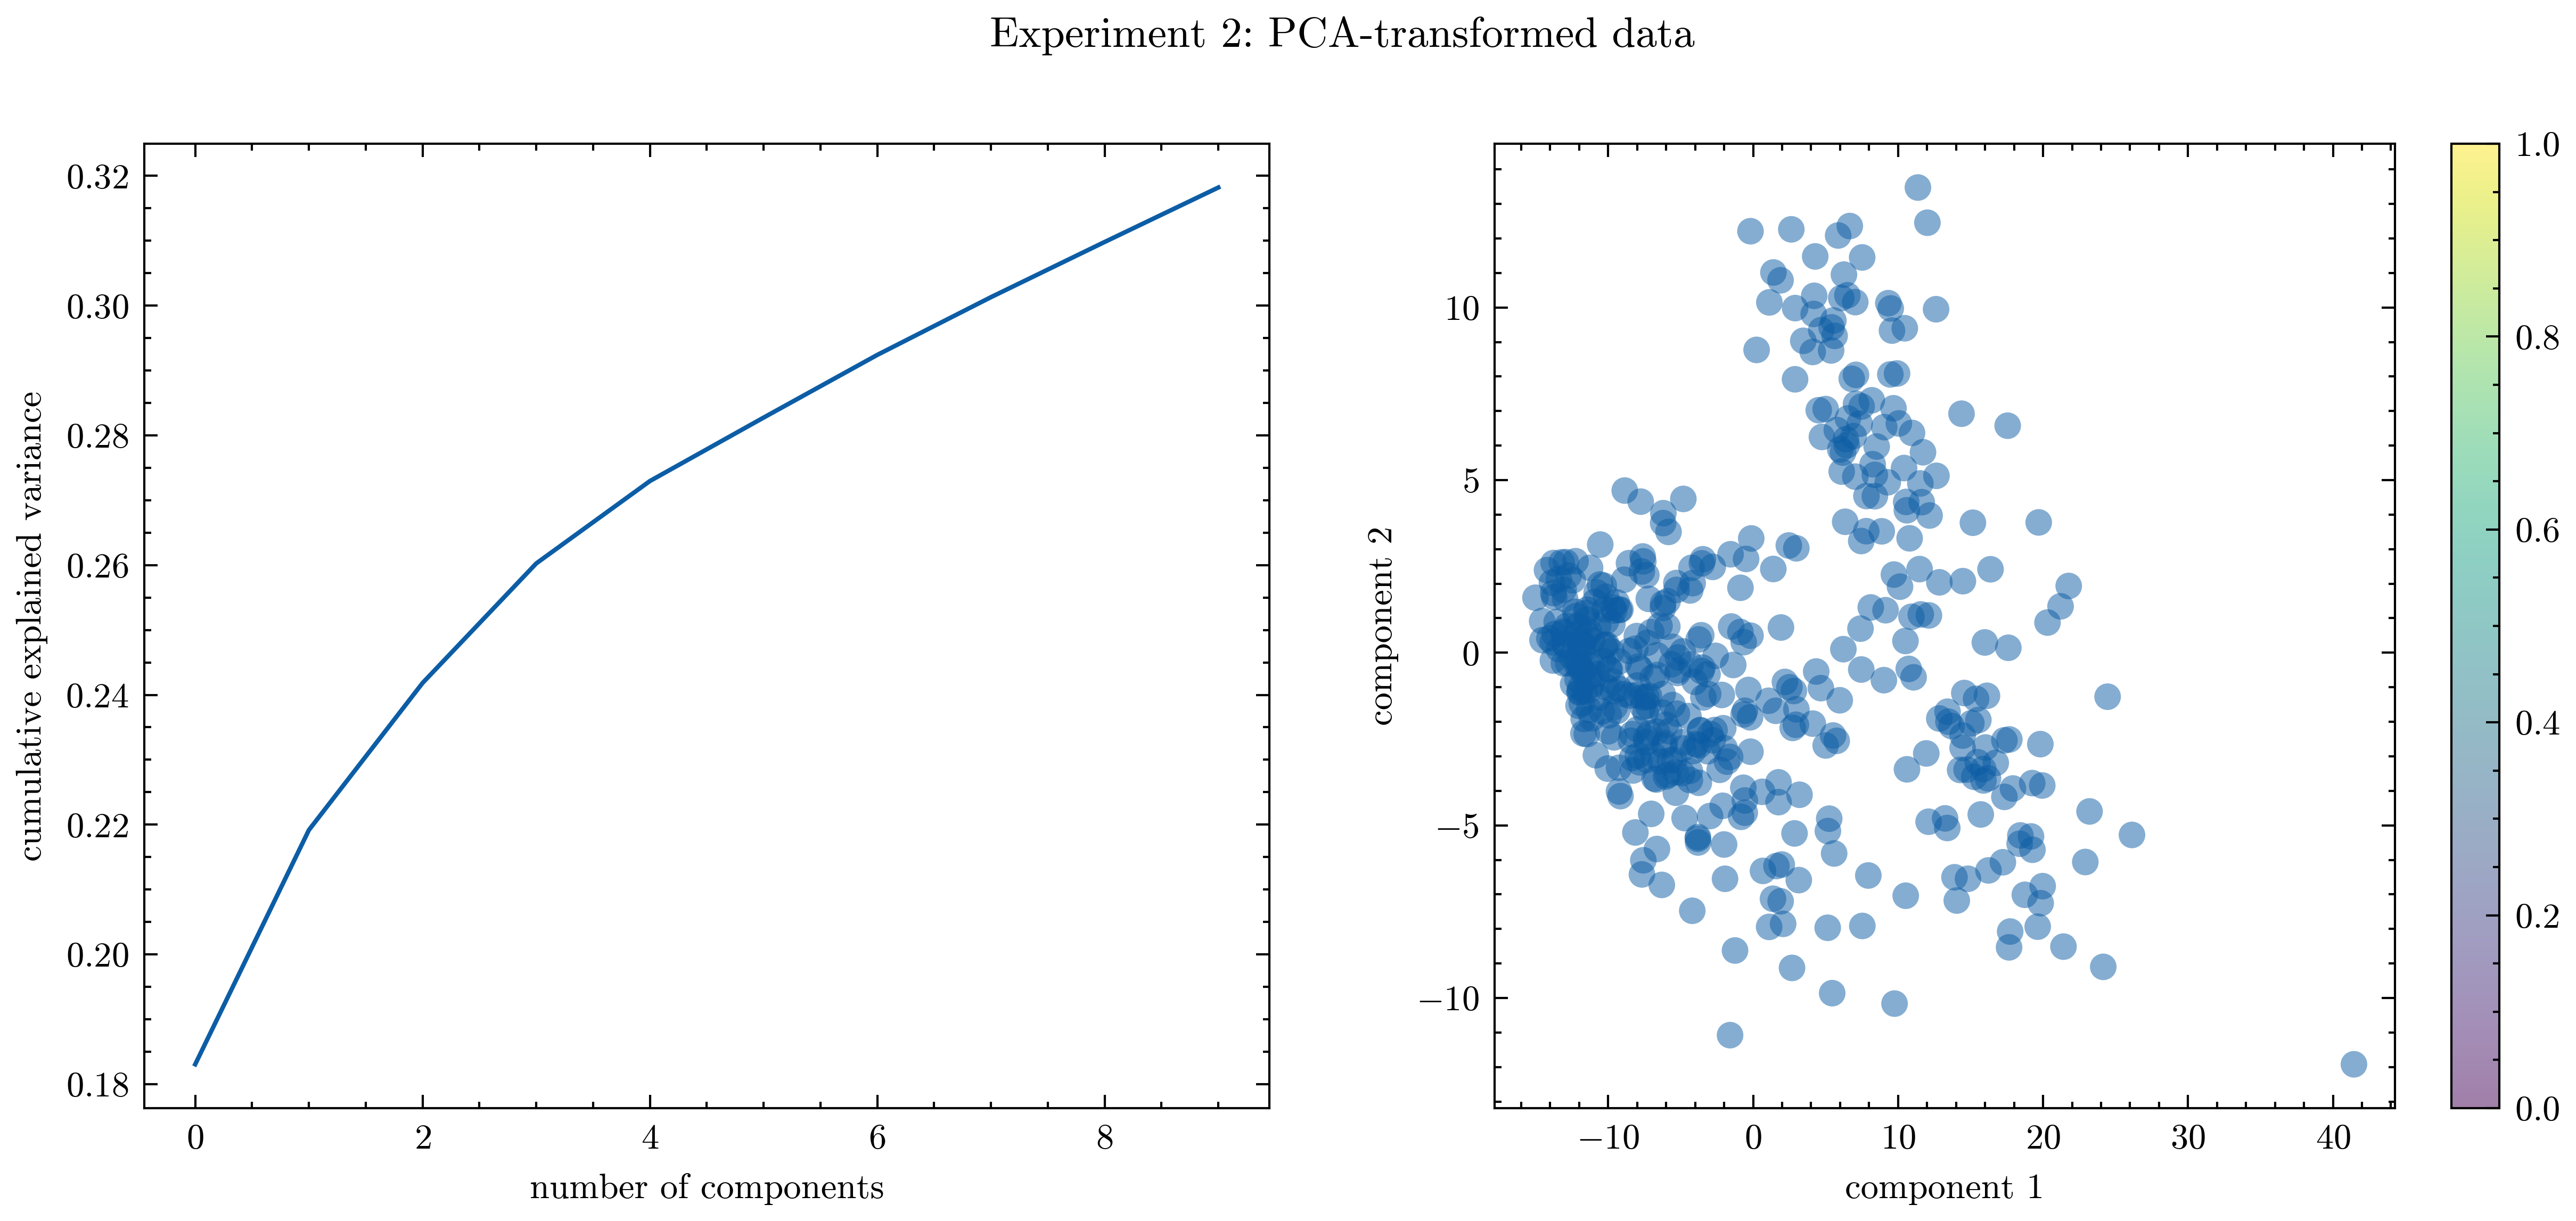

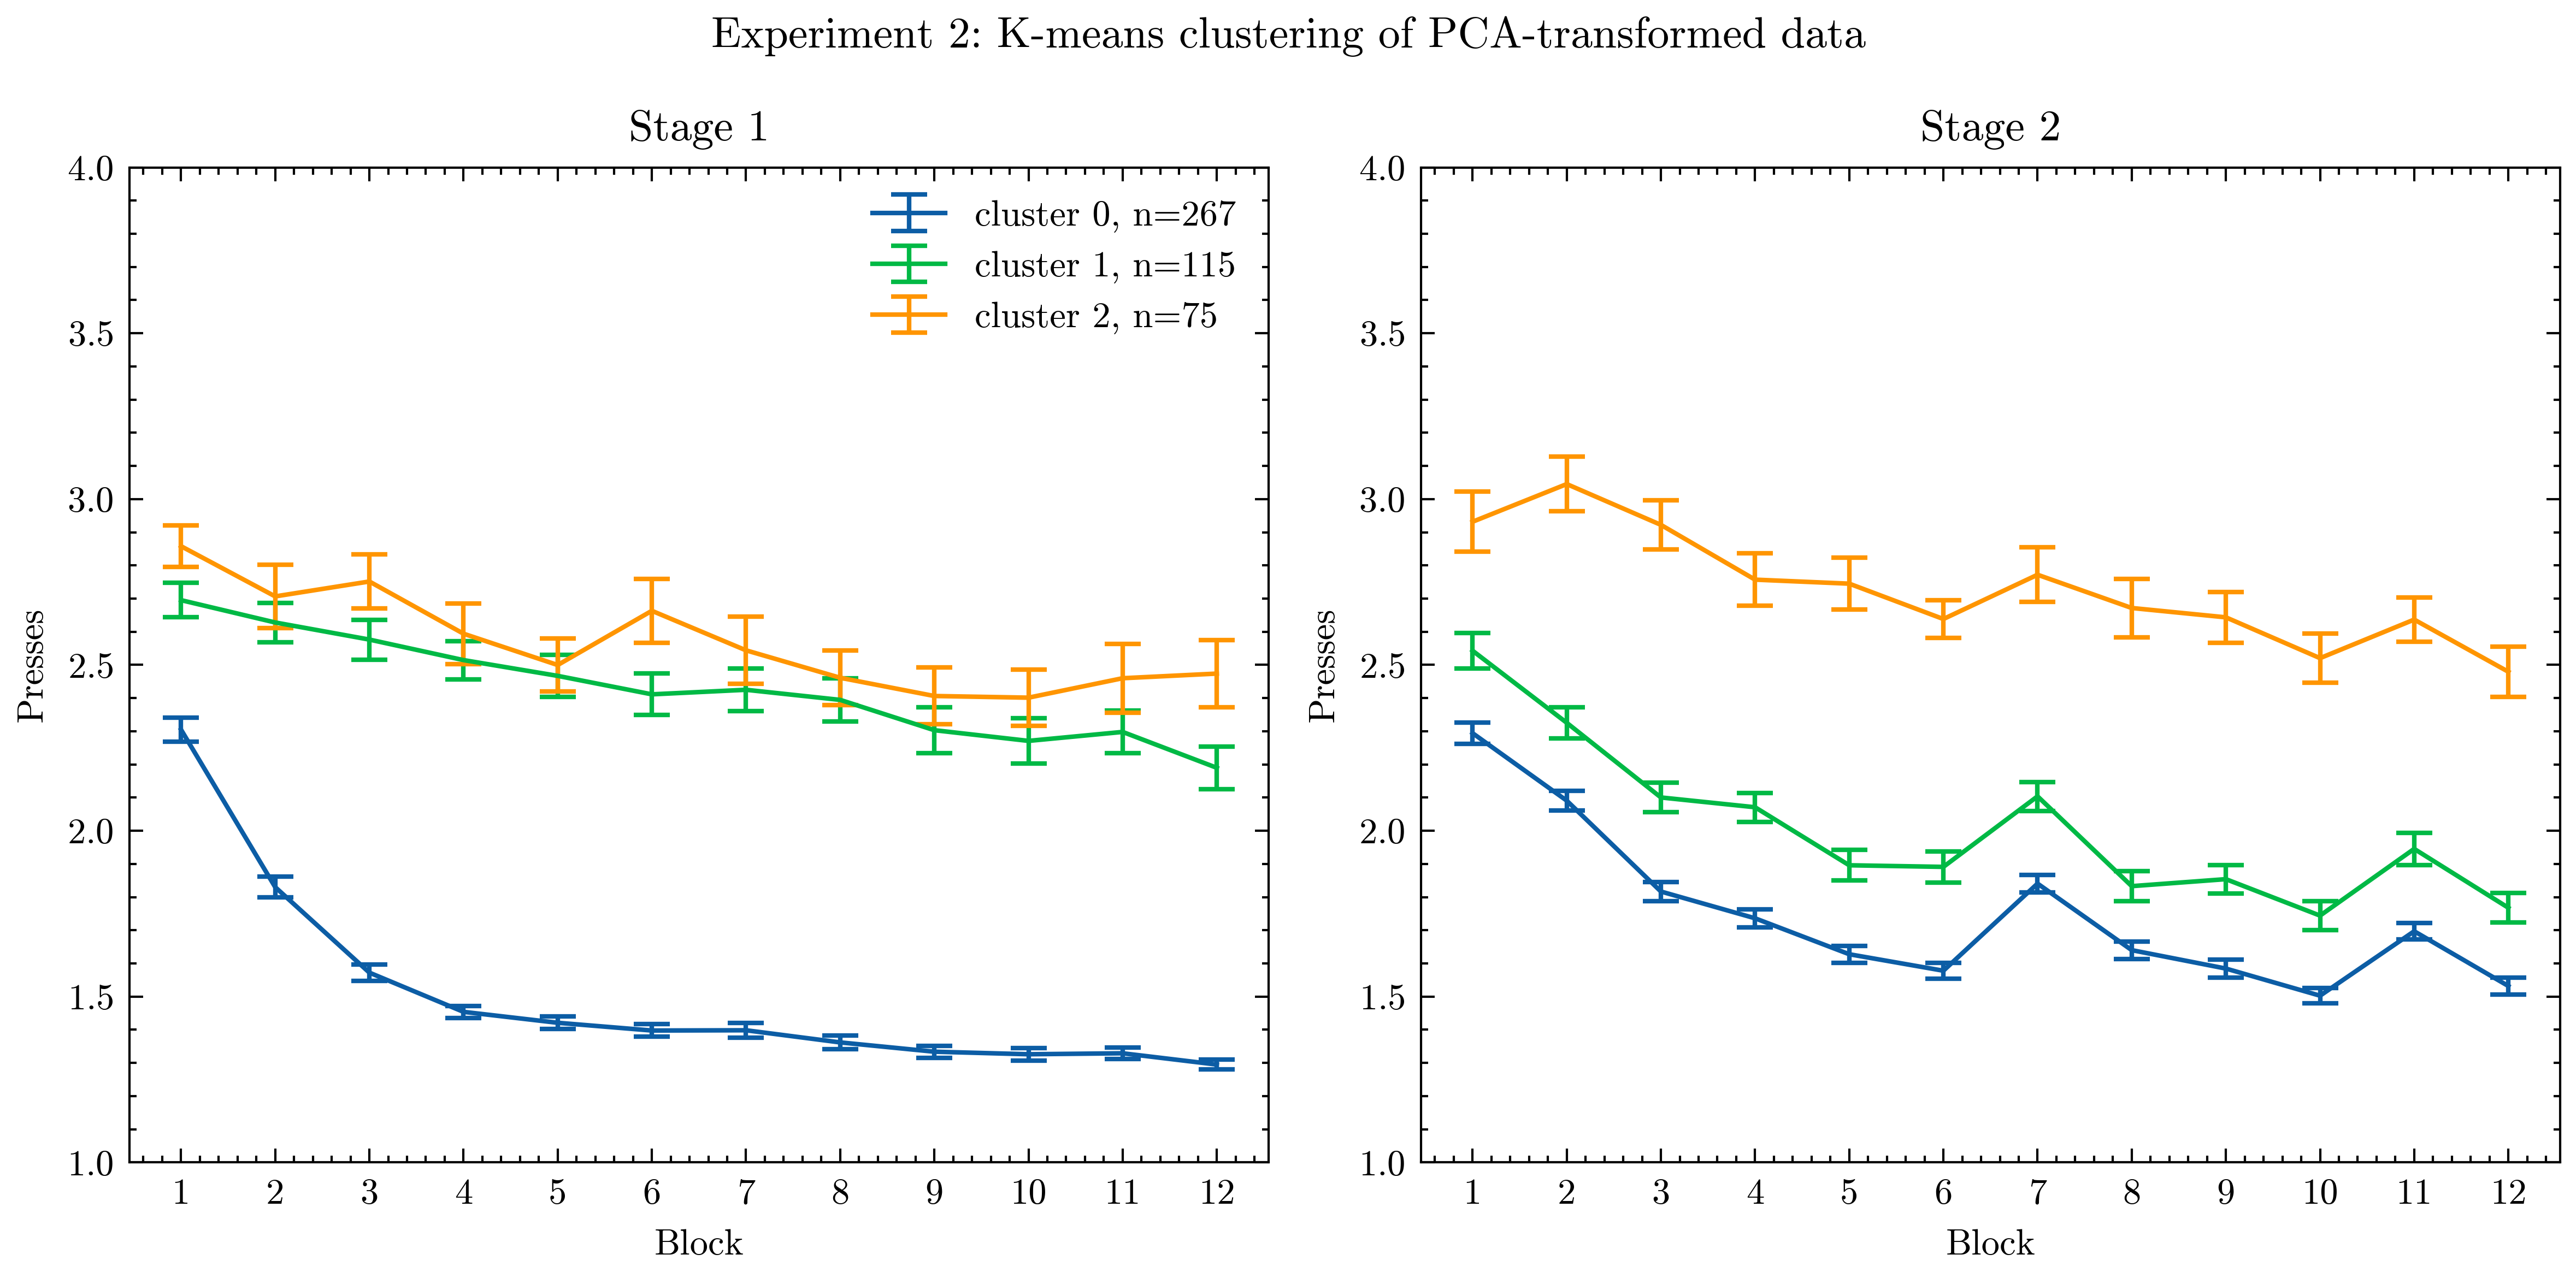

In [6]:
K = 3
cluster = -np.ones_like(meta_data['Experiment'])
for exp in [1, 2]:
    trials_to_probe = 32
    subject_inds = meta_data['Experiment']==exp
    X = np.concatenate((all_data['counter12_12'][subject_inds,0,0,:trials_to_probe], 
                        all_data['counter12_12'][subject_inds,1,0,:trials_to_probe], 
                        all_data['counter1'][subject_inds,0,:trials_to_probe], 
                        all_data['counter1'][subject_inds,1,:trials_to_probe], 
                        all_data['counter1'][subject_inds,2,:trials_to_probe], 
                        all_data['counter1'][subject_inds,3,:trials_to_probe], 
                        all_data['counter12_12'][subject_inds,0,1,:trials_to_probe], 
                        all_data['counter12_12'][subject_inds,1,1,:trials_to_probe], 
                        all_data['counter2'][subject_inds,0,:trials_to_probe], 
                        all_data['counter2'][subject_inds,1,:trials_to_probe], 
                        all_data['counter2'][subject_inds,2,:trials_to_probe], 
                        all_data['counter2'][subject_inds,3,:trials_to_probe]), axis=1)

    X = SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=4).fit_transform(X)
    pca = PCA(n_components=10).fit(X)
    X_PCA = pca.transform(X)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')

    plt.subplot(1,2,2)
    plt.scatter(X_PCA[:, 0], X_PCA[:, 1], edgecolor='none', alpha=0.5)
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.colorbar()
    plt.suptitle(f'Experiment {exp}: PCA-transformed data')
    plt.show()

    clustered = KMeans(init="k-means++", n_clusters=K).fit(X_PCA)
    mean_population_counter1, mean_population_counter2 = helpers.calc_mean(all_data, trials_to_probe=10, start_trial=0)
    cluster_means = []

    blocks = np.arange(1,13)
    fig, axes = plt.subplots(1,2,figsize=(8,4))
    for i in range(K):
        this_clu_means = np.nanmean(mean_population_counter2[subject_inds][clustered.labels_==i])
        cluster_means.append(this_clu_means)

    cluster_means_sorted = sorted(cluster_means)
    for i in range(K):
        temp = cluster[subject_inds]
        temp[clustered.labels_==np.where(cluster_means==cluster_means_sorted[i])[0]] = i
        cluster[subject_inds] = temp

    for i in range(K):
        this_clu_size = np.sum(cluster[subject_inds]==i)
        axes[0].errorbar(blocks, 
                    np.nanmean(mean_population_counter1[subject_inds][cluster[subject_inds]==i],axis=0),
                    stats.sem(mean_population_counter1[subject_inds][cluster[subject_inds]==i],axis=0,nan_policy='omit'),
                    capsize=4, label='cluster '+str(i)+', n='+str(this_clu_size))
        axes[1].errorbar(blocks, 
                    np.nanmean(mean_population_counter2[subject_inds][cluster[subject_inds]==i],axis=0),
                    stats.sem(mean_population_counter2[subject_inds][cluster[subject_inds]==i],axis=0,nan_policy='omit'),
                    capsize=4, label='cluster '+str(i)+', n='+str(this_clu_size))

    axes[0].set_xticks(blocks,blocks)
    axes[1].set_xticks(blocks,blocks)
    axes[0].set_xlabel('Block')
    axes[1].set_xlabel('Block')
    axes[0].set_ylabel('Presses')
    axes[1].set_ylabel('Presses')
    axes[0].set_ylim([1,4])
    axes[1].set_ylim([1,4])
    axes[0].legend()
    axes[0].set_title('Stage 1')
    axes[1].set_title('Stage 2')

    plt.suptitle(f'Experiment {exp}: K-means clustering of PCA-transformed data')
    plt.tight_layout()
    plt.show()

## Save cluster labels

In [7]:
meta_data['Cluster'] = cluster

In [8]:
with open('../learning_hierarchy/data.pkl', 'wb') as file:
    pickle.dump({'data': all_data, 'meta_data': meta_data}, file)